In [15]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES']='2'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [16]:
def load_samples(path, change_order=False):

    root, _ = os.path.splitext(path)

    if change_order:
        X = np.load(f'{root}-data.npy').transpose(0, 2, 3, 1)   
    else:
        X = np.load(f'{root}-data.npy')
    Y = np.eye(2)[np.load(f'{root}-label.npy')]
    
    return X, Y

In [17]:
def get_tpr_from_fpr(passing_rate, fpr, tpr):
    n_th = (fpr < passing_rate).sum()
    return tpr[n_th]

def get_sensitivity_scale_factor(model_name, background_efficiencies):
    true_label_path = '../Sample/HVmodel/data/new/mix_sample_testing.npy'
    X_test, y_test = load_samples(true_label_path)

    loaded_model = tf.keras.models.load_model(model_name)
    true_label_results = loaded_model.evaluate(x=X_test, y=y_test)

    if true_label_results[1] < 0.5:
        y_test = y_test[:,[1,0]]

    # Compute False positive rate, True positive rate
    predictions = loaded_model.predict(X_test)

    labels = np.argmax(y_test, axis=1)
    y_prob = np.array(predictions)

    fpr, tpr, _ = roc_curve(labels==1, y_prob[:,1])

    signal_efficiencies = []
    for bkg_eff in background_efficiencies:
        signal_efficiencies.append(get_tpr_from_fpr(bkg_eff, fpr, tpr))

    return np.array(signal_efficiencies) / np.array(background_efficiencies)**0.5

In [22]:
def test_model(model_name, testing_sample):
    # model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_0.0_new/'
    loaded_model = tf.keras.models.load_model(model_name)

    # testing_sample = f'../Sample/HVmodel/data/new/mix_sample_testing.npy'
    X_test, y_test = load_samples(testing_sample)

    # Compute ACC
    results = loaded_model.evaluate(x=X_test, y=y_test)
    if results[1] < 0.5:
        y_test = y_test[:,[1,0]]
        results = loaded_model.evaluate(x=X_test, y=y_test)
    print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

    # Compute AUC
    labels = y_test
    predictions = loaded_model.predict(X_test)

    y_test = np.argmax(labels, axis=1)
    y_prob = np.array(predictions)

    i = 1
    true_label_AUC = roc_auc_score(y_test==i,  y_prob[:,i])

    # Compute sensitivity scale factor
    background_efficiencies = [0.1, 0.01, 0.001]
    scale_factors = get_sensitivity_scale_factor(model_name, background_efficiencies)

    # save results
    file_name = 'CWoLa_Hunting_Hidden_Valley_best_model_training_results.csv'
    data_dict = {
                'Model Name': [model_name],
                'Testing Sample': [testing_sample],
                'ACC-true': [results[1]],
                'AUC-true': [true_label_AUC],
                'TPR/FPR^0.5: FPR=0.1': [scale_factors[0]],
                'TPR/FPR^0.5: FPR=0.01': [scale_factors[1]],
                'TPR/FPR^0.5: FPR=0.001': [scale_factors[2]],
                }

    df = pd.DataFrame(data_dict)
    if os.path.isfile(file_name):
        training_results_df = pd.read_csv(file_name)
        pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False)

In [52]:
testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_aug_1_new/'
    test_model(model_name, testing_sample)

testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing-2.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_aug_1_new/'
    test_model(model_name, testing_sample)

625/625 [==============================] - 4s 6ms/step - loss: 0.7278 - accuracy: 0.5045
Testing Loss = 0.728, Testing Accuracy = 0.505
625/625 [==============================] - 4s 6ms/step - loss: 0.8219 - accuracy: 0.5192
Testing Loss = 0.822, Testing Accuracy = 0.519
625/625 [==============================] - 3s 5ms/step - loss: 0.7030 - accuracy: 0.6052
Testing Loss = 0.703, Testing Accuracy = 0.605
625/625 [==============================] - 3s 5ms/step - loss: 0.6759 - accuracy: 0.5983
Testing Loss = 0.676, Testing Accuracy = 0.598
625/625 [==============================] - 4s 6ms/step - loss: 0.6001 - accuracy: 0.7123
Testing Loss = 0.6, Testing Accuracy = 0.712
625/625 [==============================] - 3s 5ms/step - loss: 0.6369 - accuracy: 0.6735
Testing Loss = 0.637, Testing Accuracy = 0.674
625/625 [==============================] - 3s 5ms/step - loss: 0.5897 - accuracy: 0.7276
Testing Loss = 0.59, Testing Accuracy = 0.728
625/625 [==============================] - 4s 6ms/s

In [57]:
testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_x2_new/'
    test_model(model_name, testing_sample)

testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing-2.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_x2_new/'
    test_model(model_name, testing_sample)

625/625 [==============================] - 3s 5ms/step - loss: 0.7035 - accuracy: 0.5007
Testing Loss = 0.704, Testing Accuracy = 0.501
625/625 [==============================] - 3s 5ms/step - loss: 0.7114 - accuracy: 0.5033
Testing Loss = 0.711, Testing Accuracy = 0.503
625/625 [==============================] - 3s 5ms/step - loss: 0.7096 - accuracy: 0.5008
Testing Loss = 0.71, Testing Accuracy = 0.501
625/625 [==============================] - 3s 5ms/step - loss: 0.7322 - accuracy: 0.5033
Testing Loss = 0.732, Testing Accuracy = 0.503
625/625 [==============================] - 3s 5ms/step - loss: 0.7204 - accuracy: 0.5029
Testing Loss = 0.72, Testing Accuracy = 0.503
625/625 [==============================] - 3s 5ms/step - loss: 0.7374 - accuracy: 0.5017
Testing Loss = 0.737, Testing Accuracy = 0.502
625/625 [==============================] - 3s 5ms/step - loss: 0.7313 - accuracy: 0.5027
Testing Loss = 0.731, Testing Accuracy = 0.503
625/625 [==============================] - 3s 5ms/

In [60]:
testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_copy_1_new/'
    test_model(model_name, testing_sample)

testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing-2.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_copy_1_new/'
    test_model(model_name, testing_sample)

625/625 [==============================] - 3s 5ms/step - loss: 1.1311 - accuracy: 0.5066
Testing Loss = 1.13, Testing Accuracy = 0.507
625/625 [==============================] - 3s 5ms/step - loss: 1.3492 - accuracy: 0.5119
Testing Loss = 1.35, Testing Accuracy = 0.512
625/625 [==============================] - 3s 5ms/step - loss: 1.4474 - accuracy: 0.5671
Testing Loss = 1.45, Testing Accuracy = 0.567
625/625 [==============================] - 3s 5ms/step - loss: 1.3589 - accuracy: 0.5648
Testing Loss = 1.36, Testing Accuracy = 0.565
625/625 [==============================] - 3s 5ms/step - loss: 0.9715 - accuracy: 0.6148
Testing Loss = 0.972, Testing Accuracy = 0.615
625/625 [==============================] - 3s 5ms/step - loss: 0.9414 - accuracy: 0.6471
Testing Loss = 0.941, Testing Accuracy = 0.647
625/625 [==============================] - 3s 5ms/step - loss: 0.9811 - accuracy: 0.6535
Testing Loss = 0.981, Testing Accuracy = 0.653
625/625 [==============================] - 3s 5ms/st

In [61]:
testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_only_aug_1_new/'
    test_model(model_name, testing_sample)

testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing-2.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_only_aug_1_new/'
    test_model(model_name, testing_sample)

625/625 [==============================] - 3s 5ms/step - loss: 0.7032 - accuracy: 0.5054
Testing Loss = 0.703, Testing Accuracy = 0.505
625/625 [==============================] - 3s 5ms/step - loss: 0.7020 - accuracy: 0.5021
Testing Loss = 0.702, Testing Accuracy = 0.502
625/625 [==============================] - 3s 5ms/step - loss: 0.7013 - accuracy: 0.5025
Testing Loss = 0.701, Testing Accuracy = 0.502
625/625 [==============================] - 3s 5ms/step - loss: 0.7049 - accuracy: 0.5022
Testing Loss = 0.705, Testing Accuracy = 0.502
625/625 [==============================] - 3s 5ms/step - loss: 0.7172 - accuracy: 0.5017
Testing Loss = 0.717, Testing Accuracy = 0.502
625/625 [==============================] - 3s 5ms/step - loss: 0.7105 - accuracy: 0.5028
Testing Loss = 0.711, Testing Accuracy = 0.503
625/625 [==============================] - 3s 5ms/step - loss: 0.6844 - accuracy: 0.5329
Testing Loss = 0.684, Testing Accuracy = 0.533
625/625 [==============================] - 3s 5m

In [62]:
testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_half_copy_1/'
    test_model(model_name, testing_sample)

testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing-2.npy'
for i in range(11):
    model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_half_copy_1/'
    test_model(model_name, testing_sample)

625/625 [==============================] - 3s 5ms/step - loss: 1.5378 - accuracy: 0.5001
Testing Loss = 1.54, Testing Accuracy = 0.5
625/625 [==============================] - 3s 5ms/step - loss: 1.3630 - accuracy: 0.5193
Testing Loss = 1.36, Testing Accuracy = 0.519
625/625 [==============================] - 3s 5ms/step - loss: 1.3404 - accuracy: 0.5616
Testing Loss = 1.34, Testing Accuracy = 0.562
625/625 [==============================] - 4s 5ms/step - loss: 1.5951 - accuracy: 0.5278
Testing Loss = 1.6, Testing Accuracy = 0.528
625/625 [==============================] - 3s 5ms/step - loss: 1.1848 - accuracy: 0.5994
Testing Loss = 1.18, Testing Accuracy = 0.599
625/625 [==============================] - 3s 5ms/step - loss: 1.1989 - accuracy: 0.5886
Testing Loss = 1.2, Testing Accuracy = 0.589
625/625 [==============================] - 3s 5ms/step - loss: 3.4928 - accuracy: 0.5709
Testing Loss = 3.49, Testing Accuracy = 0.571
625/625 [==============================] - 3s 5ms/step - lo

# Read results

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
file_name = './CWoLa_Hunting_Hidden_Valley_best_model_training_results.csv'
df = pd.read_csv(file_name)

In [76]:
def plot_acc_curve(madel_name_format, testing_sample, sensitivity_range, ax, label, **kwargs):
    ACC = []
    for sensitivity in sensitivity_range:
        
        model_name = madel_name_format.format(sensitivity)
        row = (df['Model Name'] == model_name) & (df['Testing Sample'] == testing_sample)

        ACC.append(df[row]['ACC-true'].mean())

    ax.plot(sensitivity_range, ACC, label=label)

In [77]:
def plot_two_acc_curve(model_name_format, save_path=None):
    fig, ax = plt.subplots(1,1, figsize=(5,4))

    testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing.npy'
    plot_acc_curve(model_name_format, testing_sample, range(11), ax, 'Original testing sample')
    testing_sample = '../Sample/HVmodel/data/new/mix_sample_testing-2.npy'
    plot_acc_curve(model_name_format, testing_sample, range(11), ax, 'New testing sample')

    ax.set_xlabel('Sensitivity $S / \sqrt{B}$')
    ax.set_ylabel('ACC')

    ax.set_xlim(-.5, 10.5)

    ax.legend(frameon=False, loc='upper left')

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
    plt.show()

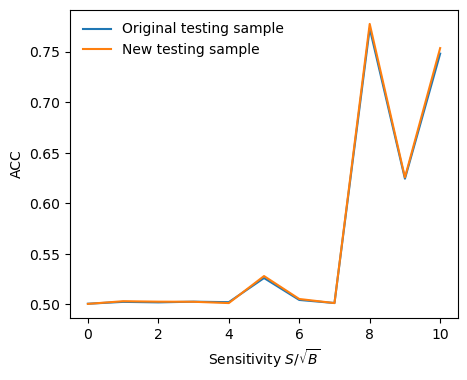

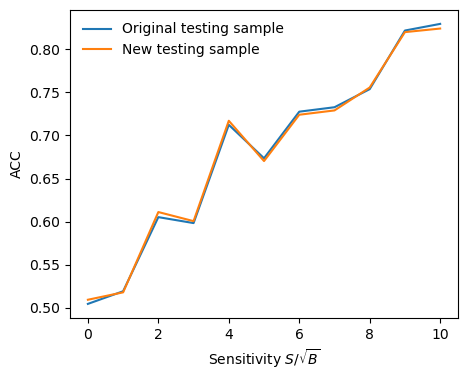

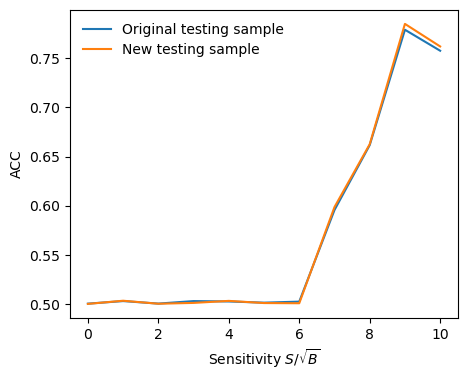

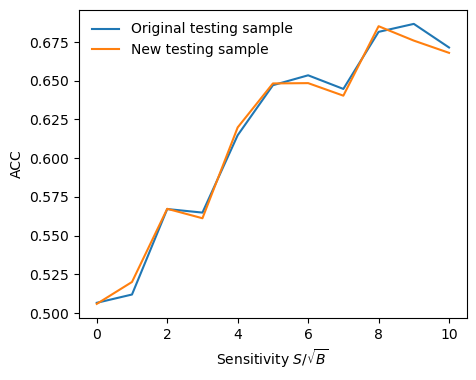

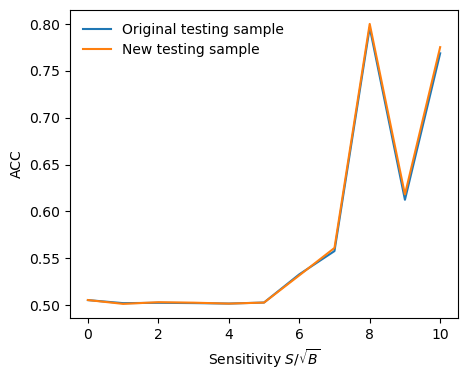

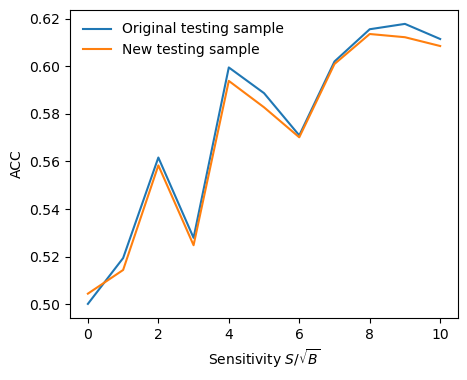

In [84]:
plot_two_acc_curve('./CNN_models/CNN_best_model_CWoLa_hunting_SB_{:.1f}_new/',
                   save_path='../figures/HVmodel_CWoLa_CNN_new_testing_sample.pdf'
                   )

plot_two_acc_curve('./CNN_models/CNN_best_model_CWoLa_hunting_SB_{:.1f}_aug_1_new/',
                   save_path='../figures/HVmodel_CWoLa_CNN_aug_1_new_testing_sample.pdf'
                   )

plot_two_acc_curve('./CNN_models/CNN_best_model_CWoLa_hunting_SB_{:.1f}_x2_new/',
                   save_path='../figures/HVmodel_CWoLa_CNN_x2_new_testing_sample.pdf'
                   )

plot_two_acc_curve('./CNN_models/CNN_best_model_CWoLa_hunting_SB_{:.1f}_copy_1_new/',
                   save_path='../figures/HVmodel_CWoLa_CNN_copy_1_new_testing_sample.pdf'
                   )

plot_two_acc_curve('./CNN_models/CNN_best_model_CWoLa_hunting_SB_{:.1f}_only_aug_1_new/',
                   save_path='../figures/HVmodel_CWoLa_CNN_only_aug_1_new_testing_sample.pdf'
                   )

plot_two_acc_curve('./CNN_models/CNN_best_model_CWoLa_hunting_SB_{:.1f}_half_copy_1/',
                   save_path='../figures/HVmodel_CWoLa_CNN_half_copy_1_new_testing_sample.pdf'
                   )